In [1]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


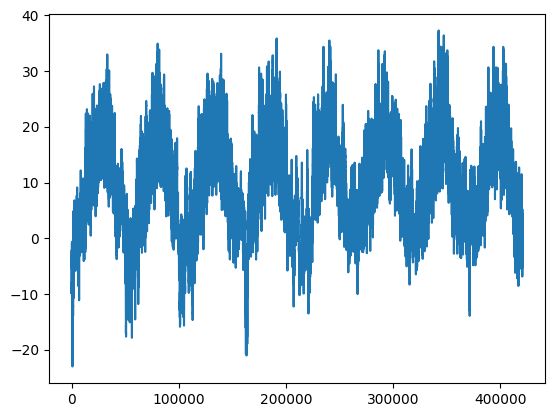

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()


In [4]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [8]:
from tensorflow import keras
import tensorflow as tf  # 잘못된 'tensroflow' 대신 'tensorflow'로 수정

from tensorflow.keras import layers


sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [9]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break


샘플 크기: (256, 120, 14)
타깃 크기: (256,)


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 13.7652 - mae: 2.8739 - val_loss: 11.0790 - val_mae: 2.6381
Epoch 2/10
819/819 [==============================] - 9s 12ms/step - loss: 9.5472 - mae: 2.4321 - val_loss: 12.3482 - val_mae: 2.8000
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.6402 - mae: 2.3161 - val_loss: 12.7948 - val_mae: 2.8394
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 8.1475 - mae: 2.2499 - val_loss: 10.5512 - val_mae: 2.5895
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.8429 - mae: 2.2044 - val_loss: 12.0541 - val_mae: 2.7648
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.6036 - mae: 2.1716 - val_loss: 10.8887 - val_mae: 2.6142
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 7.3946 - mae: 2.1410 - val_loss: 10.7763 - val_mae: 2.6147
Epoch 8/10
819/819 [==============================] - 10s

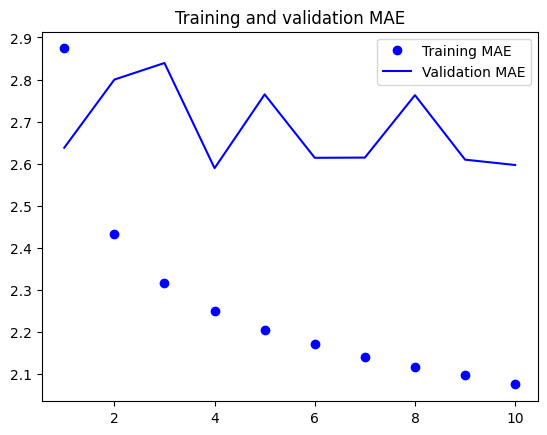

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 18s 15ms/step - loss: 22.6287 - mae: 3.7078 - val_loss: 19.0537 - val_mae: 3.4862
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 15.5813 - mae: 3.1213 - val_loss: 19.4515 - val_mae: 3.4833
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.3281 - mae: 2.9896 - val_loss: 14.9770 - val_mae: 3.0491
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 13.6345 - mae: 2.9214 - val_loss: 15.9019 - val_mae: 3.1524
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 13.0409 - mae: 2.8552 - val_loss: 15.7508 - val_mae: 3.1437
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 12.4577 - mae: 2.7922 - val_loss: 16.6319 - val_mae: 3.2427
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 11.9443 - mae: 2.7325 - val_loss: 15.5011 - val_mae: 3.1361
Epoch 8/10
819/819 [============================

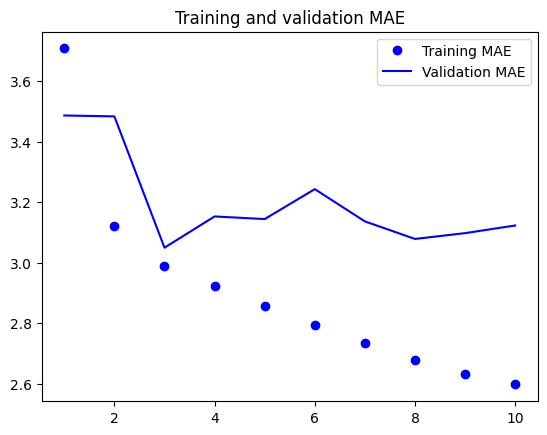

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 18s 18ms/step - loss: 40.9152 - mae: 4.6648 - val_loss: 12.3972 - val_mae: 2.6755
Epoch 2/10
819/819 [==============================] - 14s 18ms/step - loss: 10.9783 - mae: 2.5684 - val_loss: 9.2665 - val_mae: 2.3782
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 9.6497 - mae: 2.4230 - val_loss: 9.2451 - val_mae: 2.3699
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 9.1336 - mae: 2.3567 - val_loss: 9.4082 - val_mae: 2.3928
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 8.7161 - mae: 2.3059 - val_loss: 9.7116 - val_mae: 2.4339
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 8.4241 - mae: 2.2669 - val_loss: 9.9178 - val_mae: 2.4687
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 8.1789 - mae: 2.2320 - val_loss: 10.0021 - val_mae: 2.4573
Epoch 8/10
819/819 [==============================] - 15s 

In [15]:
# 넘파이로 구현한 간단한 RNN
import numpy as np
# 시계열 데이터 => timesteps
# 두개 변수가 입력 데이터다 
timesteps = 100 # 입력 시퀀스에 있는 타임스텝의 수(데이터 갯수)
input_features=32 # 입력 데이터의 차원(컬럼수)

# 입력 데이터
inputs=np.random.random((timesteps, input_features))

# 출력 저장하는 변수
output_features = 64 

# 상태를 저장하는 변수
state_t=np.zeros((output_features))


# weights 3개 필요 선언
# W : input 연산되는 W다
W=np.random.random((output_features, input_features))
# U : output 연산되는 W다
U=np.random.random((output_features, output_features)) # 64 * 64 
# b : bias
b=np.random.random((output_features, ))

In [16]:
# 입력 데이터
inputs.shape

(100, 32)

In [22]:
# 첫번째 데이터 추출
input_data=inputs[0]

In [25]:
output_t=np.dot(W,input_data) + np.dot(U,state_t) + b
output_t=np.tanh(output_t)
print(output_t.shape)
state_t=output_t

(64,)


In [26]:
print(state_t.shape)

(64,)


In [27]:
successive_outputs=[] # output_t들을 저장하는 리스트
for input_t in inputs: # 100개 데이터를 반복
    output_t = np.tanh(np.dot(W,input_data)+np.dot(U,state_t)+b)
    successive_outputs.append(output_t) # 결과(output)을 저장하는 리스트에 추가. 
    # 현재 나온 아웃풋을 다음 상태에 저장
    state_t = output_t

In [28]:
successive_outputs

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [29]:
final_output_seq=np.stack(successive_outputs, axis=0)
final_output_seq.shape

(100, 64)

In [30]:

num_features=14
inputs=keras.Input(shape=(None,num_features))
outputs=layers.SimpleRNN(16)(inputs)

In [32]:
num_features=14
steps=120 # 반복횟수
inputs=keras.Input(shape=(steps,num_features))
outputs=layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)


In [ ]:
# 스태킹 RNN 층
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
